In [1]:
# Add ldcpy root to system path
import sys
sys.path.append('..')

# Import ldcpy package
import ldcpy
%matplotlib inline

In [2]:
ds = ldcpy.open_datasets(['../data/orig.TS.100days.nc', '../data/zfp1.0.TS.100days.nc', '../data/zfp1e-1.TS.100days.nc'],
                         ['orig', 'recon', 'recon_2'])
ds

<xarray.Dataset>
Dimensions:    (ensemble: 3, ilev: 31, lat: 192, lev: 30, lon: 288, nbnd: 2, time: 100)
Coordinates:
  * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time       (time) object 1920-01-01 00:00:00 ... 1920-04-10 00:00:00
  * ilev       (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * ensemble   (ensemble) <U7 'orig' 'recon' 'recon_2'
Dimensions without coordinates: nbnd
Data variables:
    hybi       (ilev) float64 0.0 0.0 0.0 0.0 0.0 ... 0.9389 0.9636 0.9851 1.0
    gw         (lat) float64 3.382e-05 0.0002705 ... 0.0002705 3.382e-05
    hyam       (lev) float64 0.003643 0.007595 0.01436 ... 0.006255 0.001989 0.0
    P0         float64 1e+05
    hyai       (ilev) float64 0.002255 0.005032 0.01016 ... 0.003979 0.0 0.0
    time_bnds  (time, nbnd) object 1920-01-01 00:

In [3]:
ldcpy.print_stats(ds, 'TS', 'orig', 'recon')
print('----')
ldcpy.print_stats(ds, 'TS', 'orig', 'recon_2')

Comparing orig data to recon data
{
    "standard_deviation_modelled": 23.10856581306422,
    "ks_p_value": [
        0.9999947706571544,
        0.0
    ],
    "mean_error": 0.00576729244656033,
    "mean_absolute_error": 0.05852021166571864,
    "mean_observed": 274.7137027669836,
    "covariance": 533.8405046664303,
    "standard_deviation_observed": 23.10856581306422,
    "min_error": -0.361724853515625,
    "pearson_correlation_coefficient": 0.9999947706571547,
    "variance_modelled": 533.680828155477,
    "root_mean_squared_error": 0.07527297655350516,
    "max_error": 0.4058837890625,
    "variance_observed": 533.680828155477,
    "mean_modelled": 274.707935474537,
    "mean_squared_erro": 0.005666020999224538
}
----
Comparing orig data to recon_2 data
{
    "standard_deviation_modelled": 23.10856581306422,
    "ks_p_value": [
        0.9999999736752674,
        0.0
    ],
    "mean_error": 0.00038941701253255207,
    "mean_absolute_error": 0.004226026711640535,
    "mean_obser

/Users/mabouali/miniconda3/envs/ldcpy/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


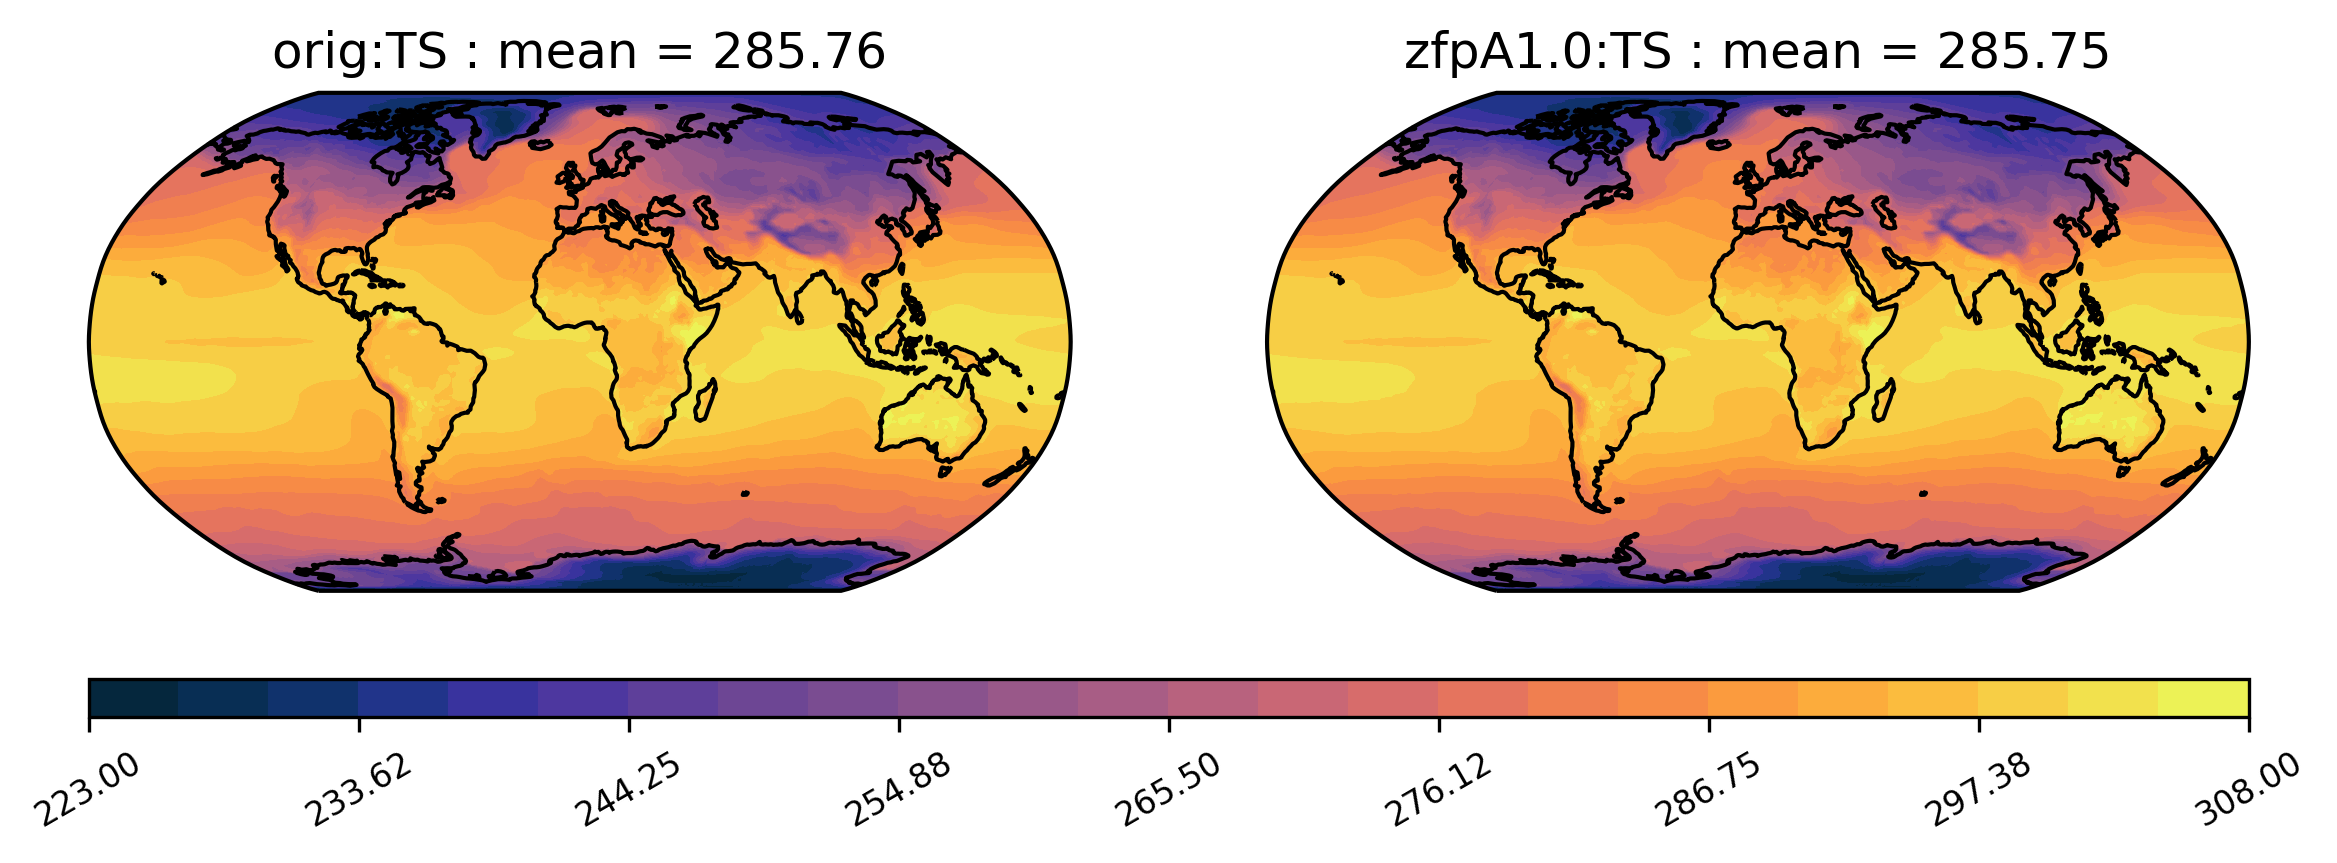

In [4]:
ldcpy.plot.compare_mean(ds, 'TS', 'orig', 'recon', 'zfpA1.0')

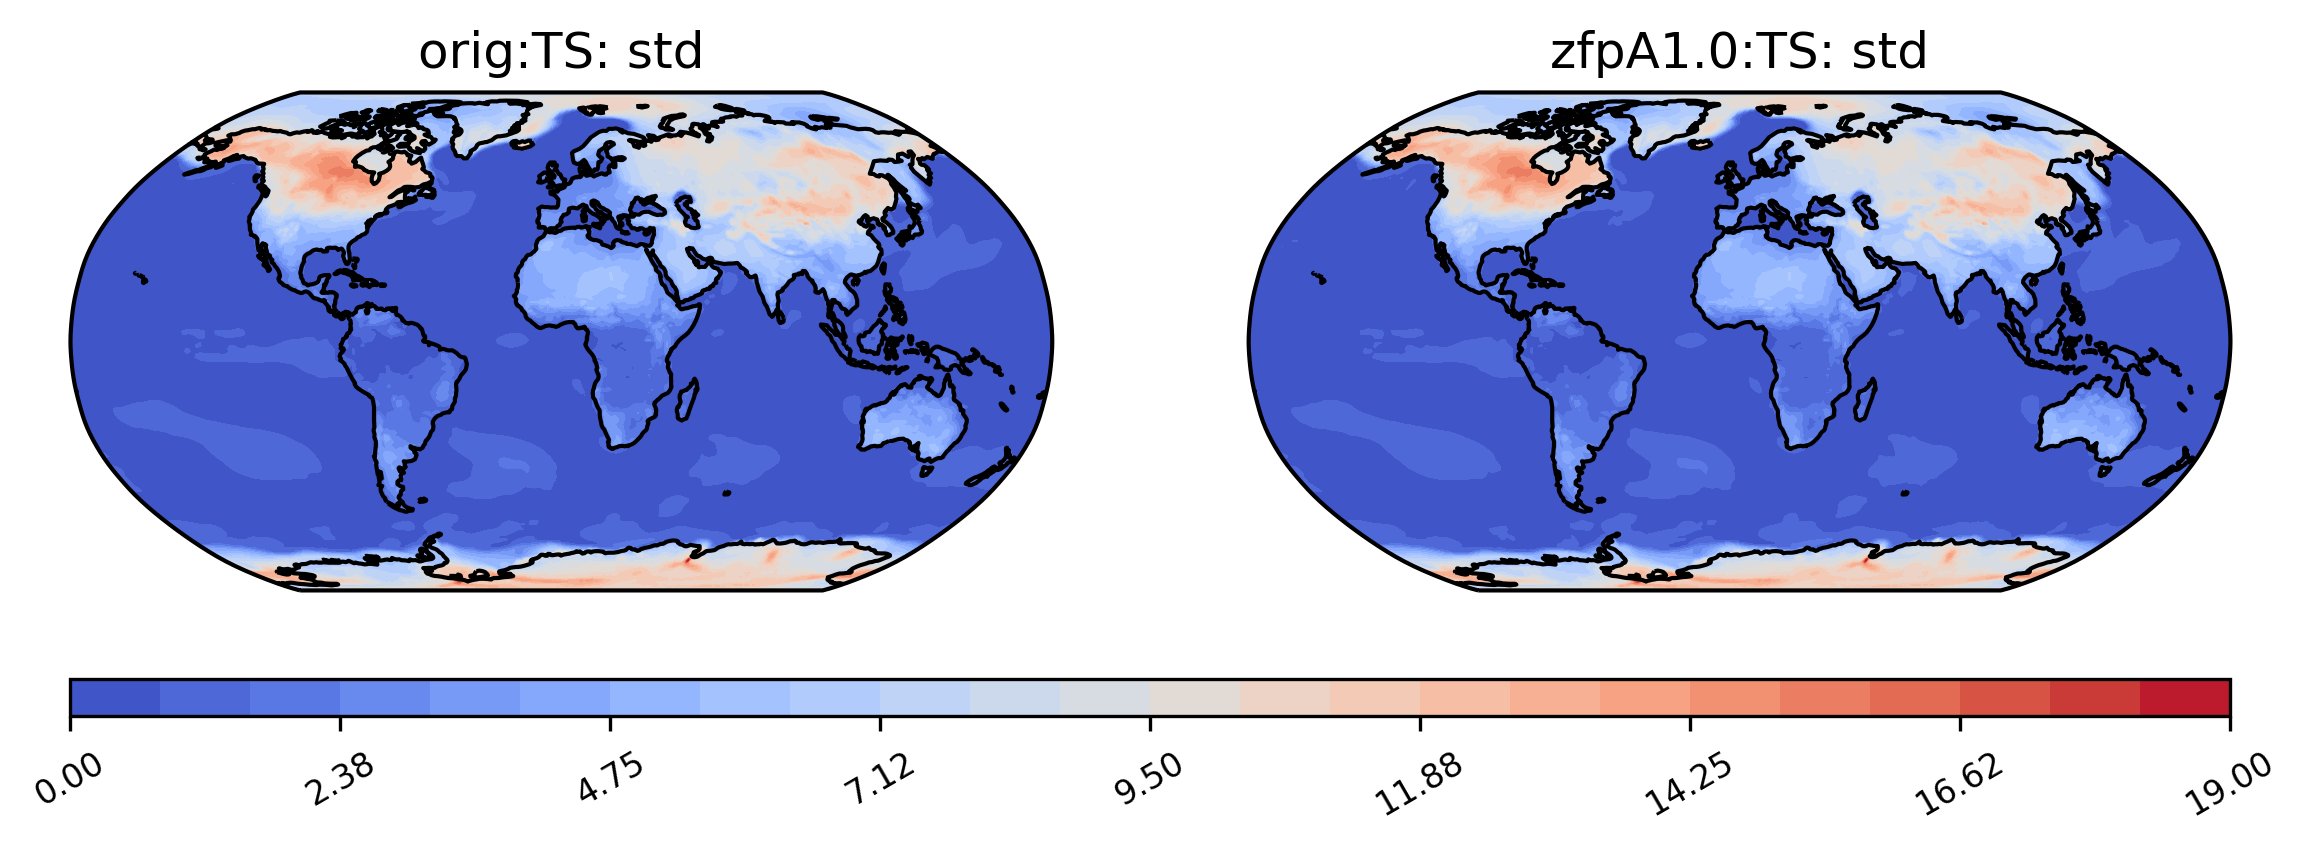

In [5]:
ldcpy.plot.compare_std(ds, 'TS', 'orig', 'recon', 'zfpA1.0')

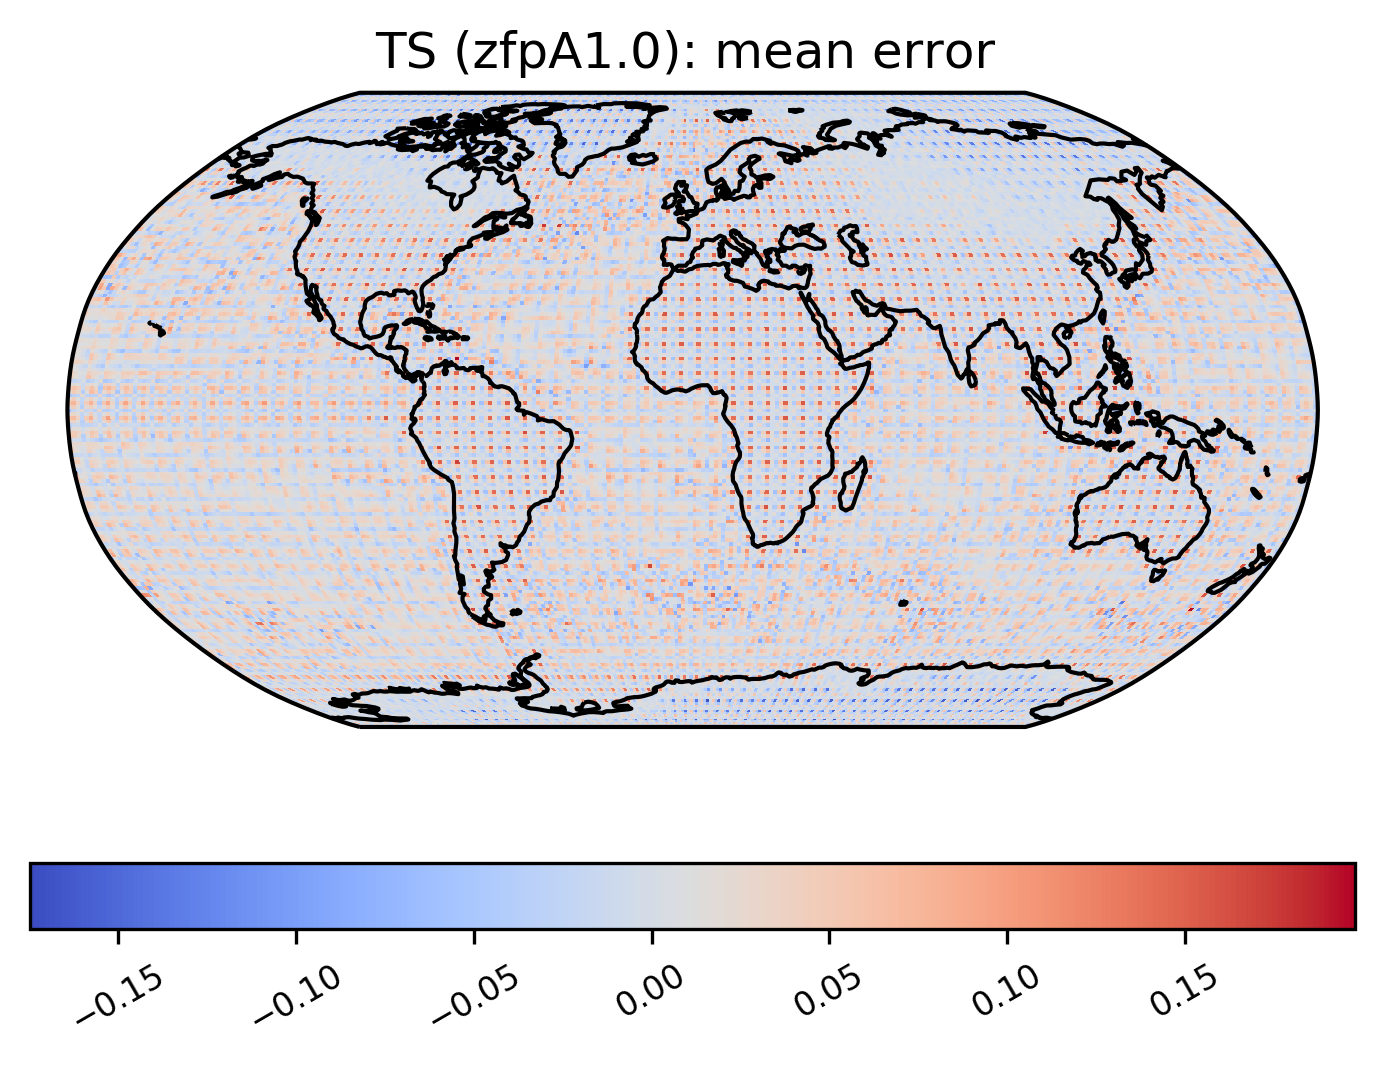

In [6]:
ldcpy.plot.mean_error(ds, 'TS', 'orig', 'recon', 'zfpA1.0')

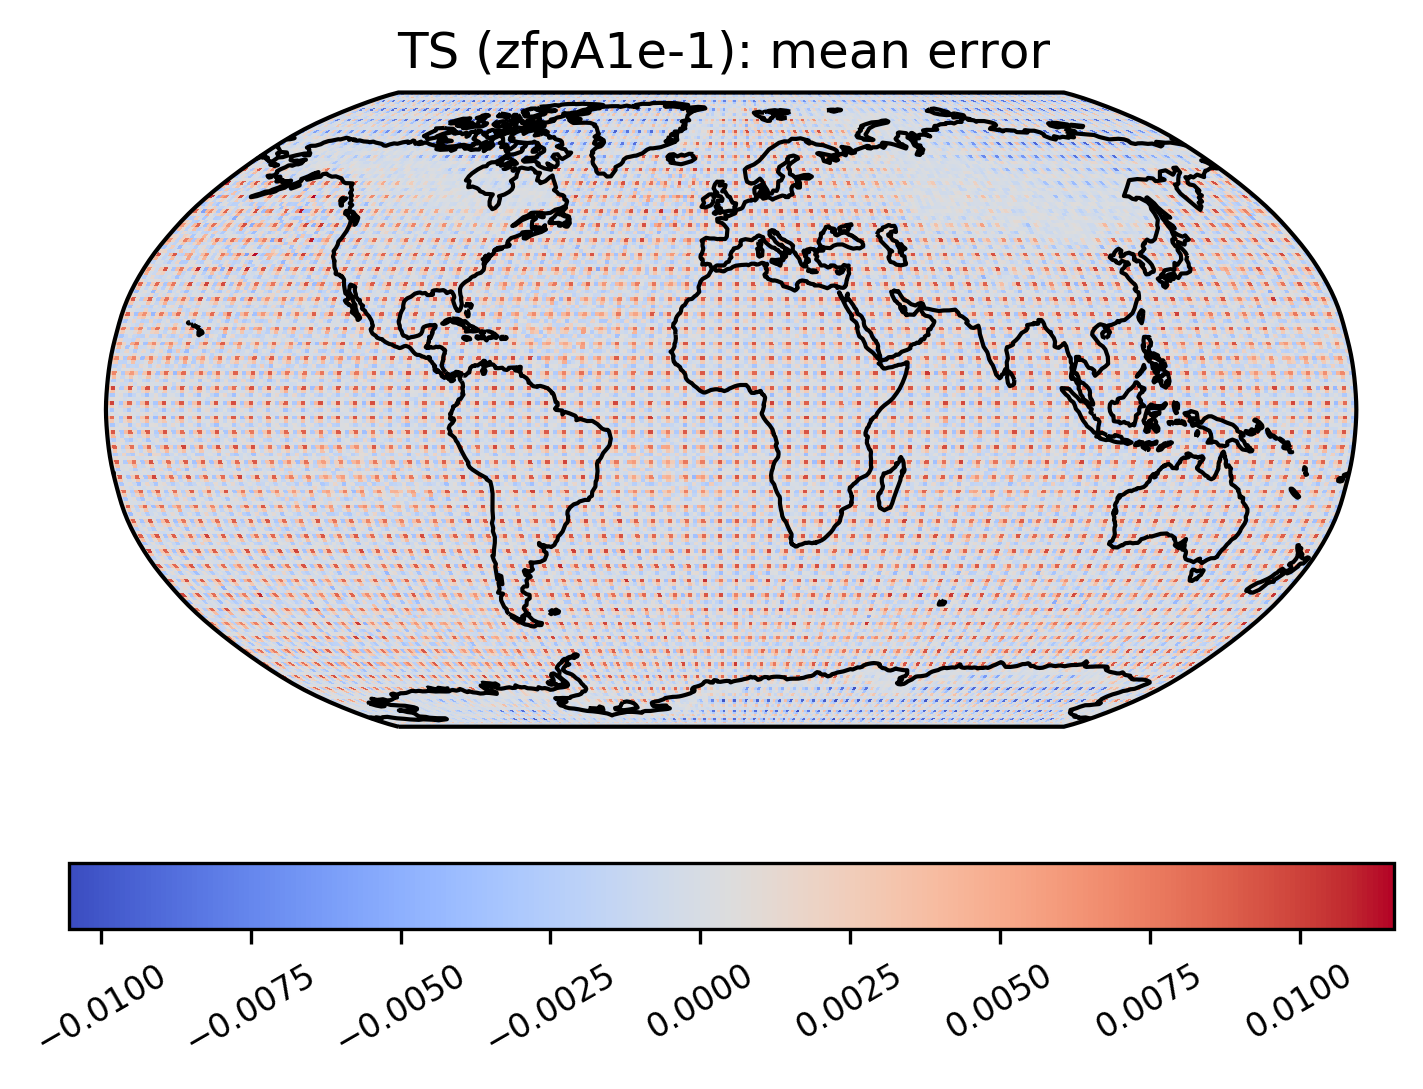

In [7]:
ldcpy.plot.mean_error(ds, 'TS', 'orig', 'recon_2', 'zfpA1e-1')

In [8]:
ldcpy.plot.error_time_series(ds, 'TS', 'orig', 'recon')